In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import PercentFormatter
from sklearn.datasets import fetch_openml

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [2]:
X, y = fetch_openml('Fashion-MNIST', return_X_y=True)
X, y = X.values, y.values.astype(int)

In [3]:
n = 1000
L = 100

classes = [1, 4, 9]
k = len(classes)

mask = np.zeros(y.shape[0], dtype=bool)
for j in classes:
    mask |= (y == j)
Xc, yc = X[mask], y[mask]
Xc -= np.mean(Xc, axis=0) # centering
for i, j in enumerate(np.sort(classes)):
    yc[yc == j] = i
T, p = Xc.shape

idx = np.arange(T)
np.random.shuffle(idx)
Xc, yc = Xc[idx], yc[idx]

get_data = lambda t: Xc[t]

setting = "$T = {} \quad n = {} \quad p = {} \quad L = {}$".format(T, n, p, L)

In [4]:
n_eigvecs = 5 # number of top empirical eigenvectors
idx_basis = [-1, -2, -3, -4, -5] # index of basis vectors

smooth_par = 0.15
h_start = 10*k
divided_warmup = True

basis = utils.basis(n, L, kind='toeplitz')[1][idx_basis]

animation = False
animation_points_per_second = 200

# Streaming

In [5]:
class_count, details = utils.streaming(get_data, T, p, L, k, n_eigvecs, basis, smooth_par, h_start, divided_warmup)
lbda, w, exp_smooth, partition0, curves, partition_ite, time_ite = details

100%|██████████| 21000/21000 [29:49<00:00, 11.73it/s] 


In [6]:
# Estimate classes via majority vote
partition = np.argmax(class_count, axis=1)

# Results

In [7]:
# Get classification error
c_err, per, per_inv = utils.get_classif_error(k, partition, yc)
print("Classification error: {:.2%}".format(c_err))

# Compute classification error vs. delay
delay_c_err = np.mean(per[partition_ite[n-1:]] != np.array([yc[t:t+n] for t in range(T-n+1)]), axis=0)[::-1]

Classification error: 6.64%


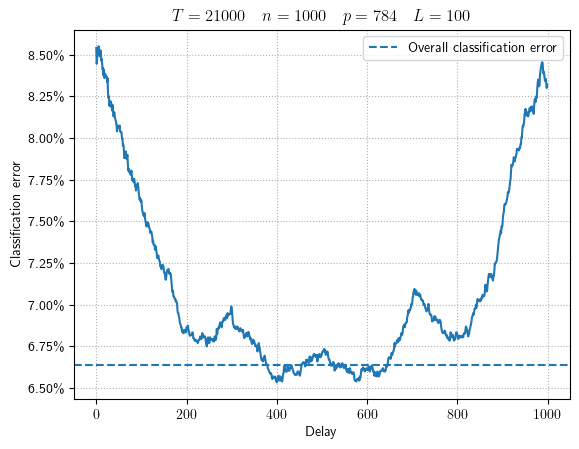

In [8]:
plt.plot(delay_c_err)
plt.axhline(y=c_err, ls='--', label="Overall classification error")
plt.grid(ls=':')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlabel("Delay")
plt.ylabel("Classification error")
plt.title(setting)
plt.legend()
plt.show()

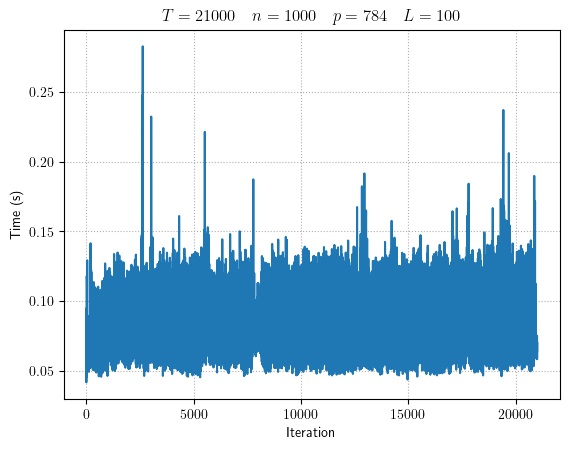

In [9]:
plt.plot(time_ite)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title(setting)
plt.show()

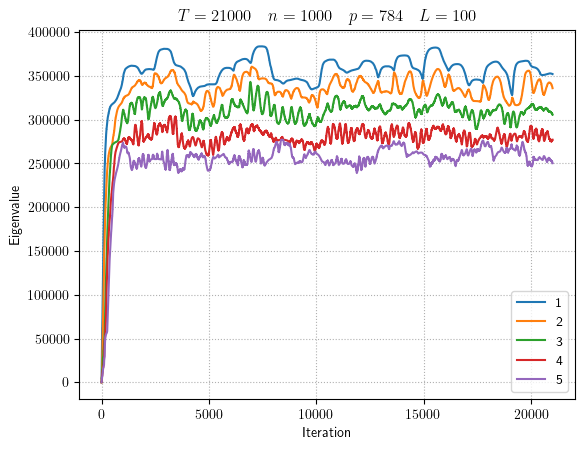

In [10]:
for i in range(n_eigvecs):
    plt.plot(lbda[i], label=i+1)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue")
plt.title(setting)
plt.legend()
plt.show()

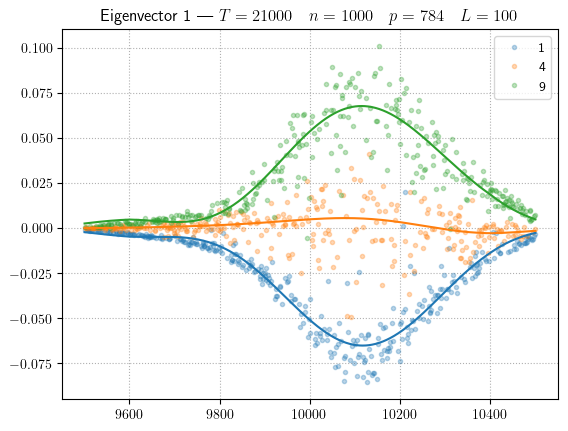

In [11]:
t = T//2
# t = n-1
i = 0

x = np.arange(max(0, t-n+1), max(n, t+1))
for j in range(k):
    color = 'C'+str(j)
    cl = (yc[max(0, t-n+1):t+1] == j)
    cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
    plt.plot(x[cl], w[t, i, cl], ls='', marker='.', alpha=.3, c=color, label=classes[j], zorder=2)
    if (divided_warmup and t <= n-1) or (not divided_warmup and t == n-1):
        mask = ((x <= t) & (partition0 == per_inv[j]))
        plt.plot(x[mask], exp_smooth[i, mask], ls='--', c=color, zorder=3)
    if t >= n-1:
        plt.plot(x, curves[t, per_inv[j], i], c=color, zorder=4)
plt.grid(ls=':')
plt.title("Eigenvector {} | ".format(i+1)+setting)
plt.legend()
plt.show()

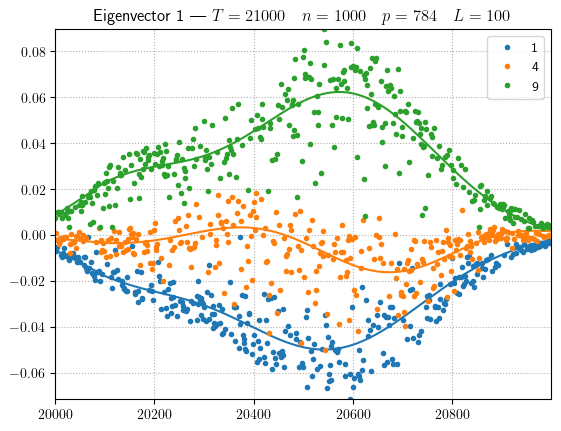

In [14]:
if animation :
    i = 0

    fig, ax = plt.subplots()

    for j in range(k):
        color = 'C'+str(j)
        ax.plot([], ls='', marker='.', label=classes[j], c=color)
        ax.plot([], ls='--', c=color)
        ax.plot([], ls='-', c=color)
    ax.grid(ls=':')
    ax.set_title("Eigenvector {} | ".format(i+1)+setting)
    ax.legend()

    def animate(t):
        x = np.arange(max(0, t-n+1), max(n, t+1))
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim((w[t, i].min(), w[t, i].max()))
        for j in range(k):
            cl = (yc[max(0, t-n+1):t+1] == j)
            cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
            ax.lines[3*j].set_data((x[cl], w[t, i, cl]))
            if (divided_warmup and t <= n-1) or (not divided_warmup and t == n-1):
                mask = ((x <= t) & (partition0 == per_inv[j]))
                ax.lines[3*j+1].set_data((x[mask], exp_smooth[i, mask]))
            if t >= n-1:
                ax.lines[3*j+2].set_data((x, curves[t, per_inv[j], i]))

    anim = FuncAnimation(fig, animate, frames=T, interval=1000/animation_points_per_second, repeat=False)
    anim.save("streaming.mp4")